In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

2022-03-02 02:43:34.065238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 02:43:34.065272: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data1 = np.loadtxt("../data/Unioncom/MMD/s1_mapped1.txt")
data2 = np.loadtxt("../data/Unioncom/MMD/s1_mapped2.txt")
type1 = np.loadtxt("../data/Unioncom/MMD/s1_type1.txt")
type2 = np.loadtxt("../data/Unioncom/MMD/s1_type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)
type_func = lambda x: x

# ComManDo Aligned

In [4]:
cm = ComManDo()
cm_data = cm.fit_transform(dataset=[data1,data2])

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:4.5494 alpha:0.7759
epoch:[200/2000] err:2.8128 alpha:0.5134
epoch:[300/2000] err:2.7323 alpha:0.5466
epoch:[400/2000] err:2.4531 alpha:0.5767
epoch:[500/2000] err:1.9160 alpha:0.6219
epoch:[600/2000] err:1.6819 alpha:0.6526
epoch:[700/2000] err:1.5806 alpha:0.6709
epoch:[800/2000] err:1.4751 alpha:0.6851
epoch:[900/2000] err:1.3157 alpha:0.6997
epoch:[1000/2000] err:1.2072 alpha:0.7121
epoch:[1100/2000] err:1.1563 alpha:0.7209
epoch:[1200/2000] err:1.1283 alpha:0.7277
epoch:[1300/2000] err:1.1095 alpha:0.7334
epoch:[1400/2000] err:1.0952 alpha:0.7383
epoch:[1500/2000] err:1.0835 alpha:0.7428
epoch:[1600/2000] err:1.0733 alpha:0.7468
epoch:[1700/2000] err:1.0644 alpha:0.7504
epoch:[1800/2000] err:1.0563 alpha:0.7536
epoch:[1900/2000] err:1.0488 alpha:0.7566
epoch:[2000/2000] err:1.0416

# UnionCom Unaligned

In [5]:
uc = ComManDo(project_mode='tsne')
uc_data = uc.fit_transform(dataset=[data1,data2])

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:4.5494 alpha:0.7759
epoch:[200/2000] err:2.8128 alpha:0.5134
epoch:[300/2000] err:2.7323 alpha:0.5466
epoch:[400/2000] err:2.4531 alpha:0.5767
epoch:[500/2000] err:1.9160 alpha:0.6219
epoch:[600/2000] err:1.6819 alpha:0.6526
epoch:[700/2000] err:1.5806 alpha:0.6709
epoch:[800/2000] err:1.4751 alpha:0.6851
epoch:[900/2000] err:1.3157 alpha:0.6997
epoch:[1000/2000] err:1.2072 alpha:0.7121
epoch:[1100/2000] err:1.1563 alpha:0.7209
epoch:[1200/2000] err:1.1283 alpha:0.7277
epoch:[1300/2000] err:1.1095 alpha:0.7334
epoch:[1400/2000] err:1.0952 alpha:0.7383
epoch:[1500/2000] err:1.0835 alpha:0.7428
epoch:[1600/2000] err:1.0733 alpha:0.7468
epoch:[1700/2000] err:1.0644 alpha:0.7504
epoch:[1800/2000] err:1.0563 alpha:0.7536
epoch:[1900/2000] err:1.0488 alpha:0.7566
epoch:[2000/2000] err:1.0416

# Figure Generation

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:4.5494 alpha:0.7759
epoch:[200/2000] err:2.8128 alpha:0.5134
epoch:[300/2000] err:2.7323 alpha:0.5466
epoch:[400/2000] err:2.4531 alpha:0.5767
epoch:[500/2000] err:1.9160 alpha:0.6219
epoch:[600/2000] err:1.6819 alpha:0.6526
epoch:[700/2000] err:1.5806 alpha:0.6709
epoch:[800/2000] err:1.4751 alpha:0.6851
epoch:[900/2000] err:1.3157 alpha:0.6997
epoch:[1000/2000] err:1.2072 alpha:0.7121
epoch:[1100/2000] err:1.1563 alpha:0.7209
epoch:[1200/2000] err:1.1283 alpha:0.7277
epoch:[1300/2000] err:1.1095 alpha:0.7334
epoch:[1400/2000] err:1.0952 alpha:0.7383
epoch:[1500/2000] err:1.0835 alpha:0.7428
epoch:[1600/2000] err:1.0733 alpha:0.7468
epoch:[1700/2000] err:1.0644 alpha:0.7504
epoch:[1800/2000] err:1.0563 alpha:0.7536
epoch:[1900/2000] err:1.0488 alpha:0.7566
epoch:[2000/2000] err:1.0416

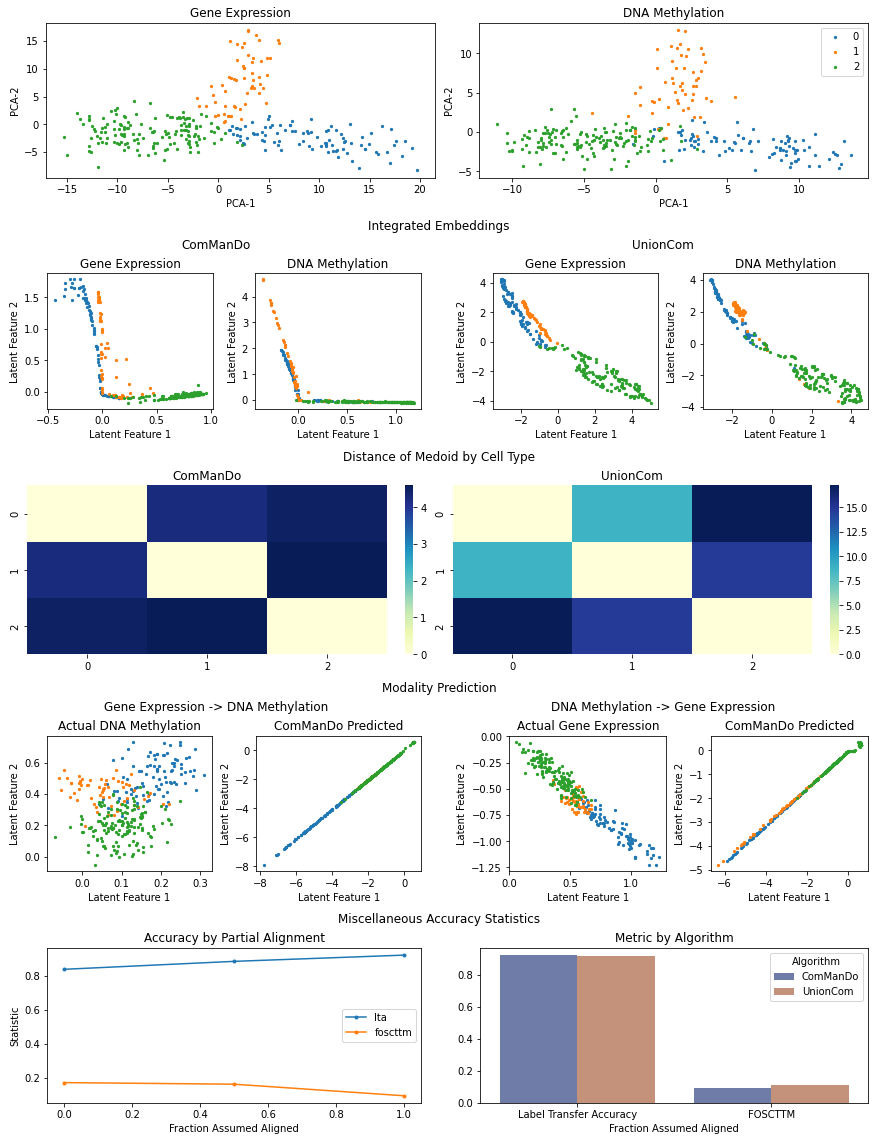

In [6]:
dataset = [data1, data2]
labels = [np.array([type_func(j) for j in i]) for i in (type1,type2)]
params = {
    'dataset_names': ['Gene Expression', 'DNA Methylation'],
    'alg_results': [uc_data],
    'alg_names': ['UnionCom'],
}
generate_figure(cm, cm_data, dataset, labels, **params)